<a href="https://colab.research.google.com/github/ChenHaoHere/Customising-your-models-with-TensorFlow-2-/blob/master/Model_subclassing_and_custom_training_loops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [0]:
# Build the model

class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.dense_1 = Dense(64, activation='relu')
    self.dense_2 = Dense(10)
    self.dropout = Dropout(0.4)

  def call(self, inputs, training=True):
    x = self.dense_1(inputs)
    if training:
      x = self.dropout(x)
    return self.dense_2(x)


In [0]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([5, 16]))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  1088      
_________________________________________________________________
dense_1 (Dense)              multiple                  650       
Total params: 1,738
Trainable params: 1,738
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [0]:
# Create a custom layer

class MyLayer(Layer):
  def __init__(self, units, input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
    self.b = self.add_weight(shape=(units,), initializer='zeros')

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3,5)
x = tf.ones((1, 5))
print(dense_layer(x))
print(dense_layer.weights)

tf.Tensor([[0.11859568 0.12629911 0.08923965]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.0407519 , -0.04449302, -0.03844872],
       [ 0.01403059,  0.07156275,  0.06113951],
       [ 0.0094814 ,  0.03644079, -0.03776183],
       [-0.01381715,  0.05363858,  0.07398784],
       [ 0.06814893,  0.00915002,  0.03032284]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [0]:
# Specify trainable weights

class MyLayer(Layer):
  def __init__(self, units, input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal', trainable=False)
    self.b = self.add_weight(shape=(units,), initializer='zeros', trainable=False)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b
dense_layer = MyLayer(3,5)

In [0]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [0]:
# Create a custom layer to accumulate means of output values

class MyLayerMean(Layer):
  def __init__(self, units, input_dim):
    super(MyLayerMean, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
    self.b = self.add_weight(shape=(units,), initializer='zeros')
    self.sum_activation = tf.Variable(initial_value=tf.zeros((units, )), trainable=False)
    self.number_call = tf.Variable(initial_value=0, trainable=False)

  def call(self, inputs):
    activations = tf.matmul(inputs, self.w) + self.b
    self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
    self.number_call.assign_add(inputs.shape[0])
    print(self.sum_activation, ' ', tf.cast(self.number_call, tf.float32))
    return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)

dense_layer = MyLayerMean(3,5)

In [0]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.06908275, -0.09463295,  0.02846216], dtype=float32)>   tf.Tensor(1.0, shape=(), dtype=float32)
[ 0.06908275 -0.09463295  0.02846216]


In [0]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [0]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Sotfmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        x = self.softmax(x)
        return x

In [0]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

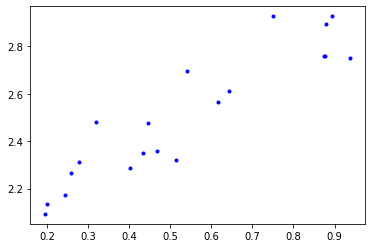

In [0]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [0]:
from tensorflow.keras.layers import Layer

In [0]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):
  def __init__(self):
    super().__init__()
    self.m = self.add_weight(shape=(1,),
                  initializer='random_normal')
    self.b = self.add_weight(shape=(1,),
                  initializer='random_normal')
  def call(self, inputs):
    return self.m*inputs+self.b

linear_regression = LinearLayer()

print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[0.07225019 0.09646001 0.0668438  0.10095213 0.05163085 0.0471513
 0.07031094 0.09680766 0.04750572 0.09653416 0.07956442 0.06432985
 0.06527267 0.07772222 0.06209304 0.08746277 0.05310456 0.05067974
 0.09776211 0.05607738], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.07263627], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.03289065], dtype=float32)>]


#### Define the loss function

In [0]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 5.989774


#### Train and plot the model

In [0]:
# Implement a gradient descent training loop for the linear regression model

lr = 0.05
steps = 20
for i in range(steps):
  with tf.GradientTape() as tape:
    predictions = linear_regression(x_train)
    loss = SquaredError(y_train, predictions)
  gradients = tape.gradient(loss, linear_regression.trainable_variables)

  linear_regression.m.assign_sub(lr * gradients[0])
  linear_regression.b.assign_sub(lr * gradients[1])

  print("Step %d, Loss %f" % (i, loss.numpy()))

Step 0, Loss 5.989774
Step 1, Loss 4.531621
Step 2, Loss 3.429172
Step 3, Loss 2.595653
Step 4, Loss 1.965462
Step 5, Loss 1.488998
Step 6, Loss 1.128760
Step 7, Loss 0.856397
Step 8, Loss 0.650471
Step 9, Loss 0.494776
Step 10, Loss 0.377059
Step 11, Loss 0.288054
Step 12, Loss 0.220759
Step 13, Loss 0.169876
Step 14, Loss 0.131403
Step 15, Loss 0.102312
Step 16, Loss 0.080314
Step 17, Loss 0.063680
Step 18, Loss 0.051100
Step 19, Loss 0.041586


m:1,  trained m:[1.0478415]
b:2,  trained b:[1.790181]


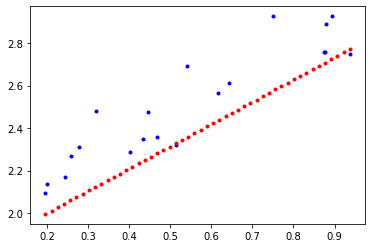

In [0]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [0]:
# Define the custom layers and model

class MyLayer(Layer):
  def __init__(self, units, input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
    self.b = self.add_weight(shape=(units,), initializer='zeros')

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)
class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Sotfmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        x = self.softmax(x)
        return x

#### Load the reuters dataset and define the class_names 

In [0]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [0]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

#### Get the dataset word index

In [0]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

In [0]:
# Print the first data example sentence



#### Preprocess the data

In [0]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

#### Define the loss function and optimizer



In [0]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [0]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [0]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

    
    
print("Duration :{:.3f}".format(time.time() - start_time))

#### Evaluate the model

In [0]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [0]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [0]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

#### Plot the learning curves

In [0]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [0]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [0]:
# Initialize a new model

class MyLayer(Layer):
  def __init__(self, units, input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
    self.b = self.add_weight(shape=(units,), initializer='zeros')

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)
class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Sotfmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        x = self.softmax(x)
        return x

model = MyModel(64, 64, 46)

#### Redefine the grad function using the @tf.function decorator

In [0]:
# Use the @tf.function decorator



#### Train the model

In [0]:
# Re-run the training loop



#### Print the autograph code

In [0]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))